### TODO:
- include back on-chain transactions FROM exchanges and add a dummy variable identifying whether it comes FROM or TO an exchange
    - the current implementation ignores transactions which go from one exchange to the other, and only considers transactions from an unknown wallet, to an exchange: we possibly lose information.
- if hourly returns are noisy: aggregate at smaller frequencies e.g. 12 hours or day - or re-query at smaller frequencies
- shift 'high' & 'low' by one to avoid forward bias for volume / volatility computation

### Assumptions undertaken:
- add intercept in design matrix
- removal of all transactions up until we have a non-zero price & removal of first two weeks of each trading period  
    - Assumption: on-chain transactions prior to quotation are left aside.
    - Upsides: allows to remove prices equal to 0 and then remove first two weeks of trading (to avoid possible extreme outliers)

We will consider the GARCH(1,1) with Student-t innovations model of the log-returns process \{$y_t$, $t\in \mathcal{Z}$\}, for $t = 1, \dots, T$:

$$    y_t = \epsilon_t \cdot h_t^{1/2} $$

where $\epsilon_t$ is a sequence of $i.i.d.$ variables $\sim$ ${\mathcal{t}}(\nu)$, 

$$ h_t = \omega + \alpha \cdot y^2_{t-1} + \beta \cdot h_{t-1}$$

for $\omega > 0$; $\alpha,\beta \geq 0$; ${\mathcal{t}}(\nu)$ denotes the Students-t distribution with $\nu$ degrees of freedom. The restriction on the GARCH parameters $\omega$, $\alpha$, $\beta$ guarantee the conditional variance's positivity.

The term $(\alpha + \beta)$ is the degree of persistence in the autocorrelation of the squares which controls the intensity of the clustering in the variance process. With a value close to one, past shocks and past variances will have a longer impact on the future conditional variance.


In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
token_data = pd.read_csv('ethereum_erc20_tokens.csv')

In [3]:
'''
The function below allows to plot nicely price and returns time-series
'''

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import seaborn as sns

def plotfigure(x,title,xlabel,df, linewdth):
    
    fig, ax = plt.subplots()
    
    df['Date'] = df['time']
       
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.set_title(title)
    
    plt.rcParams["figure.figsize"] = [10,6]
        
    ax.plot('Date', x, data = df, linewidth=linewdth)
    
    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    df['Date'] = pd.to_datetime(df['Date'])
    
    datemin = np.datetime64(str(df['Date'].iloc[0]), 'Y')
    datemax = np.datetime64(df['Date'].iloc[-1], 'Y') + np.timedelta64(1, 'Y')
    ax.set_xlim(datemin, datemax)

    
    # format the coords message box
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
    ax.grid(True)
    

    # rotates and right aligns the x labels, and moves the bottom of the
    # axes up to make room for them
    fig.autofmt_xdate()
        
    #plt.savefig(title+".png")
    # We have that title.split('_')[0] == token_initials 
    # and title.split('_')[1] == Chart_Name
    plt.savefig('./data/{}/'.format(title.split('_')[0]) + title.split('_')[1] + '.png')

    return;

In [4]:
def compute_for_token(token_address,
    token_initials,
    initial_date = None
    ):
    
    import pandas as pd
    import numpy as np
    import os
    from datetime import datetime
    import matplotlib.pyplot as plt
    import numpy as np
    from google.cloud import bigquery
    import matplotlib.pyplot as plt
    import seaborn as sns
    import scipy
    import requests
    import json
    import sklearn
    import time
    import os.path
    from arch import arch_model
    from arch.univariate import ConstantMean, GARCH, StudentsT
    
    from sklearn.model_selection import train_test_split
        
    """######################## Load the dataframe of on-chain transactions #############################"""

    # Read the .csv file containing all exchanges relevant data
    exchange_data = pd.read_csv('all_exchanges.csv')
    
    df = pd.read_csv('./data/{}/raw_big_query.csv'.format(token_initials))
    display(df.shape)
    df.block_timestamp = df.block_timestamp.apply(lambda x: datetime.strptime(x[:-6],'%Y-%m-%d %H:%M:%S') )

    # transactions towards the different exchanges
    exchange_txn_count = (
        df
        .groupby('to_address')
        .count()
        .reset_index()
        .loc[:,['to_address','token_address']]
        .merge(exchange_data, right_on='Address',left_on='to_address')
        .drop(['Address','to_address', 'Txn Count', 'Balance'], axis = 1)
        .rename(columns={'token_address':'transaction_count'})
        .sort_values('transaction_count', ascending=False)
    )
    
    #display(exchange_txn_count.head(20))
    tokens.loc[tokens.initials == token_initials,'most active exchange'] = exchange_txn_count.iloc[0,1]

    # We convert the values (stored as strings) to floats
    df.value=df.value.astype(float)

    exchange_data.Address

    # We create a dummy variable to identify variables that come from exchanges
    '''
    if df.loc[~df['from_address'].isin(exchange_data.Address)]:
        df['from_exchange'] = 1
    else:
        df['from_exchange'] = 0
    '''
    
    #df['from_exchange'] = 0 
    #display(df.tail())
    # if the 'from_address'
    #df.loc[~df['from_address'].isin(exchange_data.Address), 'from_exchange'] = 1
    #display(df.tail())
    
    # We remove all transactions that come from exchanges
    # we subselect the dataframe where the 'from_address' is not in the list of exchange addresses 
    # potential bias: transactions from exchanges to exchanges
    df = df.loc[~df['from_address'].isin(exchange_data.Address)]
    
    trans = df
    print('We found {} transactions towards exchanges.'.format( df.shape[0]) )
    tokens.loc[tokens.initials == token_initials,'transactions to exchanges'] = df.shape[0]

    address_tran_counts = (
        trans
        .groupby('from_address')
        .count()
        .sort_values(by='value', ascending=False)
        .to_address
    )
    
    trans = (
        df
        .sort_values('block_timestamp')
        .reset_index()
        .drop('index', axis=1)
    )
    
    trans = trans.rename(columns={'block_timestamp': 'time'})

    # We transform the times UTC to naive times
    trans.time = trans.time.values

    min_date = datetime.timestamp(trans.time[0])
    max_date = datetime.timestamp(trans.time.iloc[-1])
    max_date, min_date
        
    """######################## Load the dataframe of off-chain transactions #############################"""  
    
    price_raw = pd.read_csv('./data/{}/raw_crypto_compare.csv'.format(token_initials))
    price = price_raw
    price = price.sort_values('time').reset_index()

    price.loc[:,'time_readable'] = (
        price
        .time
        .apply(lambda x:datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S') )
    )
    
    # We convert the price dates into datetime objects
    price.time=price.time.apply(lambda x: datetime.fromtimestamp(x))

    if initial_date:
        price = price.loc[price.time >initial_date]

    # "volumeto" means the volume in the currency that is being traded
    # "volumefrom" means the volume in the base currency that things are traded into.
    price = price.drop(['time_readable', 'conversionSymbol','conversionType', 'open', 'volumefrom','index'], axis=1)

    # We consider the BTC volume as what we refer to as 'volume'
    price = price.rename(columns={'volumeto':'volume'}) 
    price = price[(price[['close']] != 0).all(axis=1)]
    print('We have {} observations.'.format( price.shape[0]) )
    """######################## Analysis of the data #############################"""

    # We compute the returns of the closing prices
    price.loc[:,'returns'] = np.log(price['close']).diff()
        
    # In order to transform dates to non local time
    trans.loc[:,'time']= trans.time.values

    min_time, max_time = price.time.iloc[[0,-1]].values
    
    # We only keep the transactions for which we have price data
    trans = trans.loc[(trans['time'] >= min_time)]   
    
    # We create bins of hourly intervals and we aggregate the on-chain transactions in the bins
    cut = pd.cut(trans.time, bins= price.time, duplicates='drop')
    trans_cut = trans.groupby(cut)['value'].aggregate(['count','sum'])

    # We show 5 examples of intervals for readability
    trans_cut.sample(5)
    trans_cut = trans_cut.reset_index()
    trans_cut.time = trans_cut.time.apply(lambda x:x.right)
    trans_cut.time = pd.to_datetime(trans_cut.time)

    data = (
        trans_cut
        .merge(price, left_on='time', right_on='time')
        .rename(columns={'sum':'onchain_volume', 'count':'onchain_trans'})
    )
        
    #display(data)
    
    hours_in_day = 24
    days_in_week = 7
    hours_in_week = days_in_week * hours_in_day
    data = data[2 * hours_in_week:]
    
    '''
    TEST: 
    GARCH(1,1) with student-t innovations
    '''
    am = ConstantMean(data['returns'][1:])
    am.volatility = GARCH(1, 0, 1)
    am.distribution = StudentsT()

    res = am.fit(disp = 'off', update_freq = 7)
    display(res)
    GARCH_param = pd.DataFrame({'Asset' : 'Stock', 'omega' : [res.params['omega']],
                            'alpha' : [res.params['alpha[1]']],
                            'beta' : [res.params['beta[1]']],
                            'nu' : [res.params['nu']]                            
                           })

    GARCH_param.set_index('Asset', inplace = True)

    display(GARCH_param)
    display(res.summary())   
    
    
    '''############################ PLOTS & FIGURES ##################################'''

    # We remove the rows where one value is missing
    data = (
        data
        .replace([np.inf, -np.inf], np.nan) # remove rows with infinite values
        .dropna().reset_index().drop('index', axis=1)
    )
    
    lower_bound = -100
    upper_bound = 100
    data = data.loc[(data['returns'] >= lower_bound) & (data['returns'] <= upper_bound)]
    data.sort_values('time')   
    
    nb_figures = 6
    # The style of the figure can be set globally using the matplotlib rc parameters.
    plt.rcParams['axes.grid'] = True
    plt.rcParams["figure.figsize"] = [10,6]
    
    fig, (ax1,ax11, ax5, ax2, ax3, ax4, ) = plt.subplots(nb_figures, 1, figsize=(15,10), sharex =True)
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=90)
    plt.suptitle('{} data'.format(token_initials))
    plt.subplots_adjust(hspace = 0.25) # the amount of height reserved for space between subplots
    ax1.set_title('Price evolution in BTC')
    ax1.plot(data.time, data.close)
    
    ax11.set_title('Hourly return of price of token')
    ax11.plot(data.time, data.returns)
    ax11.set_ylim((-0.3,0.3))
    
    ax5.set_title('Volume evolution in BTC')
    ax5.plot(data.time, data.volume)
    
    ax2.set_title('Rolling 7-day exchange volume evolution in BTC')
    ax2.plot(data.time,data.volume.rolling(24*7).mean())
    
    ax3.set_title('Rolling 7-day on-chain transaction count to exchanges')
    ax3.plot(data.time,data.onchain_trans.rolling(24*7).mean())
    
    ax4.set_title('Rolling 7-day on-chain volume evolution in BTC')
    ax4.plot(data.time,data.onchain_volume.rolling(24*7).mean())
    
    # Rotates and right aligns the x labels, and moves the bottom of the
    # Axes up to make room for them
    fig.autofmt_xdate()
    
    plt.savefig('./data/{}/all_plots.png'.format(token_initials))
    
    #display(data)
    
    plotfigure('close', token_initials + '_price','Daily adj. price', data,linewdth = 1)
    plotfigure('returns', token_initials + '_dailyReturns','Daily returns', data, linewdth = 0.5)
    
    data['intercept'] = 1
    
    '''
    Design matrices
    '''
    y_returns = data.returns.values
    X_returns = (
        data
        .loc[
            :,
             [
              'intercept', 'onchain_trans', 'onchain_volume',
              'high', 'low', 'volume'
             ]
            ]
        .values
    )
    
    y_volume = data.volume.values
    # Remove returns to avoid forward-looking bias
    X_volume = (
        data
        .loc[
            :,
            [
                'intercept', 'onchain_trans', 'onchain_volume',
                'high', 'low'
            ]
        ]
        .values
    )
    
    '''
    The following lines creates an iterator to iterate by pair of y_ | x_
    We would like to run for pairs of y_returns, X_returns, likewise for volume
    '''
    lis = (y_returns, X_returns, y_volume, X_volume)
    it = iter(lis)
    
    for y in it:
        
        X = next(it)
        
        import numpy as np
        from sklearn.impute import SimpleImputer

        results = {}
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=2, shuffle=False)
        X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train,y_train,test_size=0.33, random_state=2)

        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        scaler.fit(X_train_train)

        X_train_train = scaler.transform(X_train_train)
        X_train_test = scaler.transform(X_train_test)
        X_test = scaler.transform(X_test)

        '''############################ Linear Regression ##################################'''
        from sklearn.linear_model import LinearRegression

        reg = LinearRegression().fit(X_train_train, y_train_train)
              
        # If the the series is Returns, set column_name to 'returns'
        # Else set the column name to 'off-chain volume'
        col_name = 'returns' if np.array_equiv(X, X_returns) else 'off-chain volume' 
        # col_name = 'returns' if (X == X_returns).all() else 'off-chain volume' 
        
        results['linear regression score of ' + col_name] = reg.score(X_test, y_test)
        print('linear regression score of ' + col_name, reg.score(X_test, y_test))

        reg_score = reg.score(X_test, y_test)
        tokens.loc[tokens.initials == token_initials,'linear regression score of '+col_name] = reg_score

        # Start the scatter plots here
        nb_rows = 2
        nb_columns = 1
        
        fig, (ax_linreg, ax_tree) = plt.subplots(nb_rows, nb_columns, figsize=(15,10), sharex =True)
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.suptitle('{} linear regression and RF Regressor for '.format(token_initials) + col_name)
        ax_linreg.scatter(y_test, reg.predict(X_test))
        ax_linreg.plot(y_test,y_test, 'k')
        ax_linreg.set_title(
            'Linear regression of ' + col_name +
            ' prediction vs. true validation data token {}\n score: {:.3f} '
            .format(token_initials, reg_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
        
        '''############################ RF Regressor ##################################'''
        from sklearn.ensemble import RandomForestRegressor
        
        clf = RandomForestRegressor(n_estimators = 100)
        clf = clf.fit(X_train_train, y_train_train)
        results['RF Regressor score of ' + col_name] = clf.score(X_test,y_test)
        print('RF Regressor score of ' + col_name, clf.score(X_test,y_test) )
        clf_score = clf.score(X_test,y_test) 

        tokens.loc[tokens.initials == token_initials,'RF Regressor score of ' + col_name] = clf_score

        ax_tree.scatter(y_test, clf.predict(X_test))
        ax_tree.plot(y_test,y_test, 'k')
        ax_tree.set_title(
            'RF Regressor prediction of ' + col_name +
            ' vs. true validation data token {}\n score:{:.3f} '
            .format(token_initials, clf_score)
        )
        # Rotates and right aligns the x labels, and 
        # Moves the bottom of the axes up 
        # To make room for them
        fig.autofmt_xdate()
    
        plt.savefig('./data/{}/regression_plots.png'.format(token_initials))
        plt.savefig('./data/{}/'.format(token_initials) + col_name + '_regression_plots.png')


### Run the program

In [5]:
tokens = os.listdir('data')

In [6]:
# We keep the tokens for which we have both on-chain and off-chain data
tokens = pd.Series(tokens)
keep = (
    tokens
    .apply(lambda x: 
           os.path.exists('data/{}/raw_big_query.csv'.format(x)) 
           and 
           os.path.exists('data/{}/raw_crypto_compare.csv'.format(x))
    )
)
remove_tokens = tokens.loc[~keep]
tokens = tokens.loc[keep]
tokens = token_data.merge(tokens.to_frame(), left_on='initials', right_on=0).drop(0, axis=1) #token_data contains all info
tokens.loc[:,'linear model score'] = 0
tokens.loc[:,'transactions to exchanges'] = 0
tokens = tokens.drop(['holders','daily_volume','price'], axis = 1)
#tokens.dtypes

### Test procedure

(173535, 9)

We found 171231 transactions towards exchanges.
We have 19966 observations.


/home/vm/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                62599.8
Distribution:      Standardized Student's t   AIC:                          -125190.
Method:                  Maximum Likelihood   BIC:                          -125150.
                                              No. Observations:                19628
Date:                      Fri, Dec 20 2019   Df Residuals:                    19623
Time:                              16:54:36   Df Model:                            5
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

,omega,alpha,beta,nu
Asset,,,,
Stock,0.000005,0.2,0.78,4.145944


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                      returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                62599.8
Distribution:      Standardized Student's t   AIC:                          -125190.
Method:                  Maximum Likelihood   BIC:                          -125150.
                                              No. Observations:                19628
Date:                      Fri, Dec 20 2019   Df Residuals:                    19623
Time:                              16:54:36   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.1162e-05  4.490e-05     -1.139      0.255 [-1.392e-04,3.685e-05]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.5886e-06  5.944e-09    771.999      0.000 [4.577e-06,4.600e-06]
alpha[1]       0.2000  7.314e-03     27.346 1.215e-164     [  0.186,  0.214]
beta[1]        0.7800  8.008e-03     97.408      0.000     [  0.764,  0.796]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             4.1459      0.114     36.463 4.239e-291 [  3.923,  4.369]
========================================================================

Covariance estimator: robust

WARNING: The optimizer did not indicate successful convergence. The message was
Inequality constraints incompatible. See convergence_flag.
"""

/home/vm/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


linear regression score of returns 0.00018701736294324253
RF Regressor score of returns -0.467425982661718
linear regression score of off-chain volume 0.02284876987335494
RF Regressor score of off-chain volume 0.21358038161571627


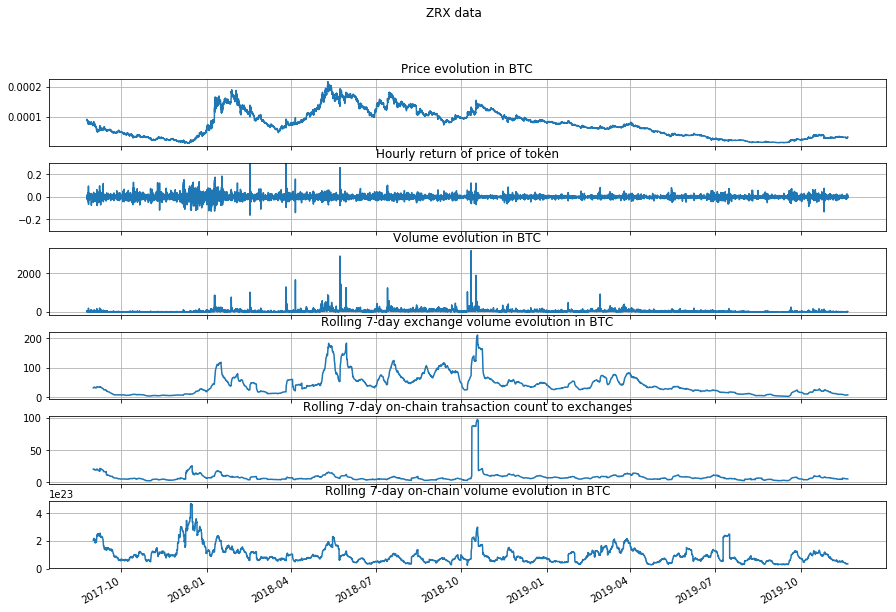

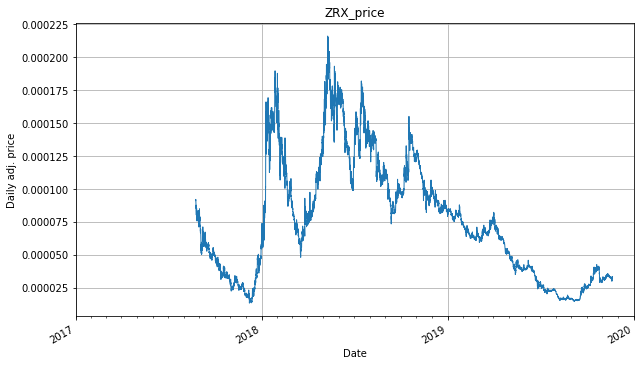

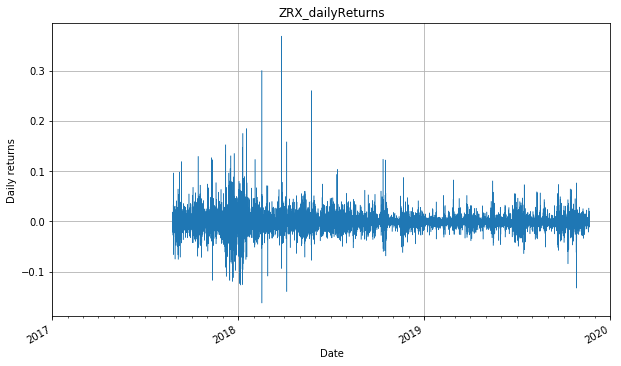

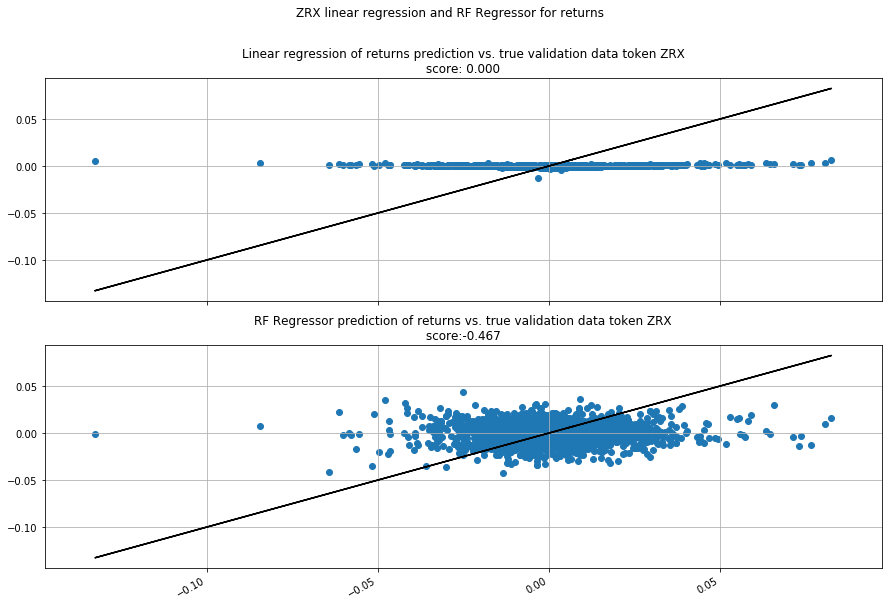

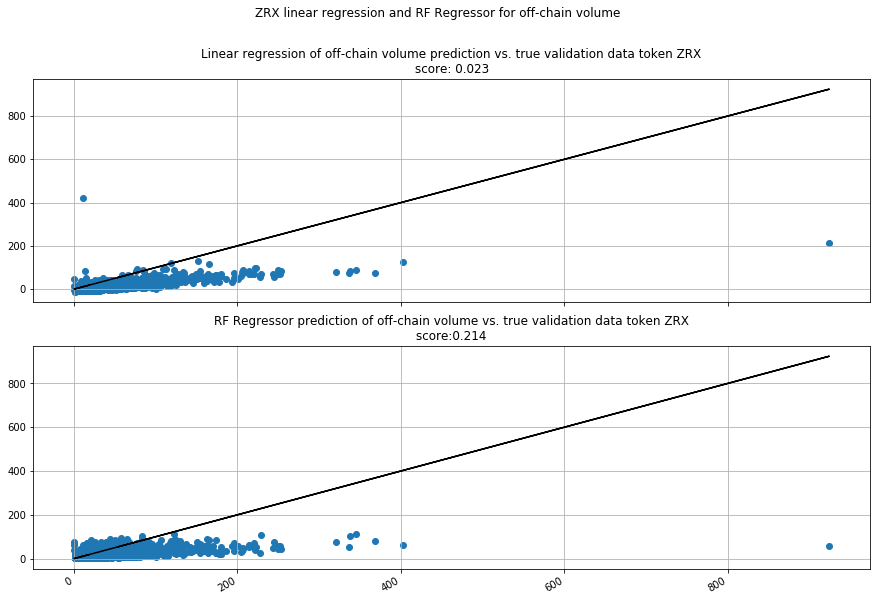

In [7]:
# hardcode our test procedure
compute_for_token('0xe41d2489571d322189246dafa5ebde1f4699f498', 'ZRX')

### Run the program for all tokens

In [ ]:
for i in range(len(tokens.initials)):
    try:
        print(i)
        compute_for_token(tokens.address[i], tokens.initials[i])
    except Exception as e:
        print(e)

In [ ]:
tokens.to_csv('tokens_all_regressions.csv', index=False)
tokens.head(1)

### Printing results in LaTeX

In [ ]:
import pandas as pd
tokens = pd.read_csv('tokens_all_regressions.csv')
tokens.head(3)

In [ ]:
# Make a proper format to improve clarity
tokens['market_cap'] = (
    tokens['market_cap']
    .str.replace(',', '')
    .str.replace('$', '')
    .astype(int)
)
tokens = tokens.sort_values('market_cap', ascending=False)
tokens.head(3)

In [ ]:
tokens['market_cap'] = (tokens['market_cap']/1000000).apply(lambda x: '${:,.2f}M'.format(x))
tokens.head(3)

### Print ML techniques scores

In [ ]:
nb_decimals_to_round_to = 2 

print(tokens
      .drop(['address','description',
             'initials','linear model score',
             'most active exchange','transactions to exchanges'], axis=1)
      .round(
          {
              'RF Regressor score of returns': nb_decimals_to_round_to,
              'RF Regressor score of off-chain volume': nb_decimals_to_round_to,
              'linear regression score of returns': nb_decimals_to_round_to,
              'linear regression score of off-chain volume': nb_decimals_to_round_to,
          }
      )
      .reset_index(drop=True)
      .rename(columns = 
              {
                  'RF Regressor score of returns' : 'RF Regressor returns score',
                  'RF Regressor score of off-chain volume' : 'RF Regressor volume score',
                  'linear regression score of returns' : 'Lin-reg returns score',
                  'linear regression score of off-chain volume' : 'Lin-reg volume score'                  
              }
       )
      .to_latex()
)

### Print the descriptions

In [ ]:
lzt = tokens.columns.tolist()
lzt.remove('description')
lzt.remove('name')
pd.options.display.max_colwidth = 100
print(tokens
      .drop(lzt, axis=1)
      .to_latex()
)